In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_eight_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 7].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_seventh_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 6].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per calcolare l'intervallo di confidenza
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

# Funzione per rimuovere '_vec' dalla fine del nome del file
def remove_vec_suffix(file_name):
    if file_name.endswith('_vec.csv'):
        return file_name[:-8]
    else:
        return file_name

# Funzione per ottenere il numero finale dal nome del file
def get_file_number(file_name):
    match = re.search(r'\d+$', file_name)
    if match:
        return int(match.group())
    else:
        return 0  # Se non viene trovato nessun numero, restituisci 0

# Funzione per analizzare un singolo file CSV
def analyze_csv(file_path, ignored_files, results):
    df = pd.read_csv(file_path)
    description = df[df['attrname'] == 'description']['attrvalue'].values
    description = description[0] if len(description) > 0 else "N/A"

    is_N = any("N=1" in val for val in df[df['attrname'] == 'description']['attrvalue'].values)

    pDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "pDistribution")
    vDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "vDistribution")
    lifeTime = get_eight_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")
    lifeTime_arrival = get_seventh_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")

    if pDistribution is None or vDistribution is None or lifeTime is None:
        ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
        return

    min_length = min(len(pDistribution), len(vDistribution), len(lifeTime))
    pDistribution = pDistribution[:min_length]
    vDistribution = vDistribution[:min_length]
    lifeTime = lifeTime[:min_length]

    queueLength_Q1 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q1", "queueLength:vector")
    queueLength_Q2 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q2", "queueLength:vector")

    if is_N:
        queueLength_Q2 = np.zeros(len(queueLength_Q1))
    else: 
        if queueLength_Q1 is None or queueLength_Q2 is None:
                ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
                return

    Cw = 1  # Definisci il valore di Cw

    mean_W, ci_low_W, ci_high_W = confidence_interval(lifeTime)
    U_values = vDistribution - pDistribution - (Cw * lifeTime)
    mean_U, ci_low_U, ci_high_U = confidence_interval(U_values)
    max_W = np.max(lifeTime)
    min_W = np.min(lifeTime)
    mean_max_W, ci_low_max_W, ci_high_max_W = confidence_interval(lifeTime, confidence=0.95)
    mean_min_W, ci_low_min_W, ci_high_min_W = confidence_interval(lifeTime, confidence=0.95)
    mean_queueLength_Q1 = np.mean(queueLength_Q1)
    mean_queueLength_Q2 = np.mean(queueLength_Q2)
    mean_utilization_Q1, ci_low_utilization_Q1, ci_high_utilization_Q1 = confidence_interval(queueLength_Q1 / np.sum(queueLength_Q1))
    mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))

    results.append({
        "File": remove_vec_suffix(os.path.basename(file_path)),
        "File_Number": get_file_number(remove_vec_suffix(os.path.basename(file_path))),
        "Description": description,
        "mean_W": mean_W,
        "ci_low_W": ci_low_W,
        "ci_high_W": ci_high_W,
        "mean_U": mean_U,
        "ci_low_U": ci_low_U,
        "ci_high_U": ci_high_U,
        "max_W": max_W,
        "ci_low_max_W": ci_low_max_W,
        "ci_high_max_W": ci_high_max_W,
        "min_W": min_W,
        "ci_low_min_W": ci_low_min_W,
        "ci_high_min_W": ci_high_min_W,
        "mean_utilization_Q1": mean_utilization_Q1,
        "ci_low_utilization_Q1": ci_low_utilization_Q1,
        "ci_high_utilization_Q1": ci_high_utilization_Q1,
        "mean_utilization_Q2": mean_utilization_Q2,
        "ci_low_utilization_Q2": ci_low_utilization_Q2,
        "ci_high_utilization_Q2": ci_high_utilization_Q2,
        "mean_queueLength_Q1": mean_queueLength_Q1,
        "mean_queueLength_Q2": mean_queueLength_Q2,
        "lifeTime": ",".join(map(str, lifeTime)),
        "lifeTime_arrival": ",".join(map(str, lifeTime_arrival))
    })

# Funzione per analizzare tutti i file CSV in una directory
def analyze_directory(directory_path):
    ignored_files = []
    results = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv') and not file_name.endswith('_sca.csv'):
            file_path = os.path.join(directory_path, file_name)
            analyze_csv(file_path, ignored_files, results)
    
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by='File_Number')  # Ordina per numero del file
        results_df.drop(columns=['File_Number'], inplace=True)  # Rimuovi la colonna File_Number
        results_df.to_csv(os.path.join('./results_summary_convalidation.csv'), index=False)
    
    if ignored_files:
        ignored_files_sorted = sorted(ignored_files, key=lambda x: get_file_number(x[0]))  # Ordina gli ignorati per numero del file
        ignored_df = pd.DataFrame(ignored_files_sorted, columns=['File', 'Description'])
        ignored_df.to_csv(os.path.join('./ignored_files_convalidation.csv'), index=False)

# Esempio di utilizzo
directory_path = './results_CSV_convalidation'
analyze_directory(directory_path)


Studio Transiente Iniziale

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataframe si chiami 'results_df'
# Creiamo un dataframe dai dati forniti
results_df = pd.read_csv('./results_summary_convalidation.csv')

# Convertiamo le colonne lifeTime e lifeTime_arrival da stringhe a liste di numeri
results_df['lifeTime'] = results_df['lifeTime'].apply(lambda x: list(map(float, x.split(','))))
results_df['lifeTime_arrival'] = results_df['lifeTime_arrival'].apply(lambda x: list(map(float, x.split(','))))

# Filtri aggiuntivi
parameters = [
    'Strategy=0', 'Strategy=1', 'lambda=1.25', 'lambda=2', 'm1=0.25', 'N=2', 'N=3'
]

# Funzione per creare e visualizzare i plot per una determinata strategia o parametro
def plot_strategy(dataframe, label, window_size=1000, time_limit=20):
    # Ridurre il campione di dati analizzati
    sample_size = int(len(dataframe) * 1)
    sampled_df = dataframe.head(sample_size)
    
    # Creazione del DataFrame per i job completati in base al tempo di arrivo
    arrival_times = []
    mean_W_values = []
    utilization_Q1_values = []
    utilization_Q2_values = []
    queue_length_Q1_values = []
    queue_length_Q2_values = []

    for index, row in sampled_df.iterrows():
        arrival_times.extend(row['lifeTime_arrival'])
        mean_W_values.extend([row['mean_W']] * len(row['lifeTime_arrival']))
        utilization_Q1_values.extend([row['mean_utilization_Q1']] * len(row['lifeTime_arrival']))
        utilization_Q2_values.extend([row['mean_utilization_Q2']] * len(row['lifeTime_arrival']))
        queue_length_Q1_values.extend([row['mean_queueLength_Q1']] * len(row['lifeTime_arrival']))
        queue_length_Q2_values.extend([row['mean_queueLength_Q2']] * len(row['lifeTime_arrival']))

    # Creiamo un DataFrame per facilitare le operazioni
    time_df = pd.DataFrame({
        'arrival_time': arrival_times,
        'mean_W': mean_W_values,
        'utilization_Q1': utilization_Q1_values,
        'utilization_Q2': utilization_Q2_values,
        'queue_length_Q1': queue_length_Q1_values,
        'queue_length_Q2': queue_length_Q2_values
    })

    # Filtrare il DataFrame fino al tempo limite
    time_df = time_df[time_df['arrival_time'] <= time_limit]

    # Ordiniamo per tempo di arrivo
    time_df = time_df.sort_values(by='arrival_time').reset_index(drop=True)

    # Calcolo della media mobile per i parametri in funzione del tempo
    time_df['mean_W_moving_avg'] = time_df['mean_W'].rolling(window=window_size).mean()
    time_df['utilization_Q1_moving_avg'] = time_df['utilization_Q1'].rolling(window=window_size).mean()
    if 'utilization_Q2' in time_df:
        time_df['utilization_Q2_moving_avg'] = time_df['utilization_Q2'].rolling(window=window_size).mean()
    time_df['queue_length_Q1_moving_avg'] = time_df['queue_length_Q1'].rolling(window=window_size).mean()
    if 'queue_length_Q2' in time_df:
        time_df['queue_length_Q2_moving_avg'] = time_df['queue_length_Q2'].rolling(window=window_size).mean()

    # Metodo per calcolare il transiente iniziale basato sulla stabilizzazione della media mobile in funzione del tempo
    def calculate_transient_initial(time_series, value_series, window_size=100, threshold=0.01):
        moving_avg = value_series.rolling(window=window_size).mean()
        stabilization_point = None

        for i in range(window_size, len(moving_avg)):
            if np.abs(moving_avg[i] - moving_avg[i-1]) < threshold:
                stabilization_point = i
                break

        if stabilization_point is not None:
            return time_series[stabilization_point]
        else:
            return None

    # Calcoliamo il transiente iniziale per i parametri in funzione del tempo
    transient_initial_mean_W = calculate_transient_initial(time_df['arrival_time'], time_df['mean_W'])
    transient_initial_utilization_Q1 = calculate_transient_initial(time_df['arrival_time'], time_df['utilization_Q1'])
    transient_initial_queue_length_Q1 = calculate_transient_initial(time_df['arrival_time'], time_df['queue_length_Q1'])
    
    if 'utilization_Q2' in time_df:
        transient_initial_utilization_Q2 = calculate_transient_initial(time_df['arrival_time'], time_df['utilization_Q2'])
    else:
        transient_initial_utilization_Q2 = None

    if 'queue_length_Q2' in time_df:
        transient_initial_queue_length_Q2 = calculate_transient_initial(time_df['arrival_time'], time_df['queue_length_Q2'])
    else:
        transient_initial_queue_length_Q2 = None

    print(f'Transiente iniziale per mean_W ({label}): {transient_initial_mean_W}')
    print(f'Transiente iniziale per utilization_Q1 ({label}): {transient_initial_utilization_Q1}')
    if transient_initial_utilization_Q2 is not None:
        print(f'Transiente iniziale per utilization_Q2 ({label}): {transient_initial_utilization_Q2}')
    print(f'Transiente iniziale per queue_length_Q1 ({label}): {transient_initial_queue_length_Q1}')
    if transient_initial_queue_length_Q2 is not None:
        print(f'Transiente iniziale per queue_length_Q2 ({label}): {transient_initial_queue_length_Q2}')

    transient_values = [
        transient_initial_mean_W,
        transient_initial_utilization_Q1,
        transient_initial_utilization_Q2,
        transient_initial_queue_length_Q1,
        transient_initial_queue_length_Q2
    ]

    transient_values = [value for value in transient_values if value is not None]
    transient_average = np.mean(transient_values) if transient_values else None

    print(f'Media dei transienti iniziali ({label}): {transient_average}')

    # Numero di simulazioni analizzate
    num_simulations = len(sampled_df)

    # Grafico per visualizzare i parametri in funzione del tempo con il transiente iniziale annotato
    plt.figure(figsize=(14, 8))
    plt.suptitle(f'Parametri in funzione del tempo ({label}) - Simulazioni analizzate: {num_simulations}')
    
    plt.subplot(3, 1, 1)
    plt.plot(time_df['arrival_time'], time_df['mean_W'], label='Mean W')
    plt.plot(time_df['arrival_time'], time_df['mean_W_moving_avg'], label='Moving Average Mean W', color='red')
    if transient_initial_mean_W is not None:
        plt.axvline(x=transient_initial_mean_W, color='yellow', linestyle='--', label='Transiente Iniziale')
    plt.xlabel('Time')
    plt.ylabel('Mean W')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(3, 1, 2)
    plt.plot(time_df['arrival_time'], time_df['utilization_Q1'], label='Utilization Q1')
    plt.plot(time_df['arrival_time'], time_df['utilization_Q1_moving_avg'], label='Moving Average Utilization Q1', color='red')
    if transient_initial_utilization_Q1 is not None:
        plt.axvline(x=transient_initial_utilization_Q1, color='purple', linestyle='--', label='Transiente Iniziale Q1')
    if 'utilization_Q2' in time_df:
        plt.plot(time_df['arrival_time'], time_df['utilization_Q2'], label='Utilization Q2')
        plt.plot(time_df['arrival_time'], time_df['utilization_Q2_moving_avg'], label='Moving Average Utilization Q2', color='blue')
        if transient_initial_utilization_Q2 is not None:
            plt.axvline(x=transient_initial_utilization_Q2, color='yellow', linestyle='--', label='Transiente Iniziale Q2')
    plt.xlabel('Time')
    plt.ylabel('Utilization')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(3, 1, 3)
    plt.plot(time_df['arrival_time'], time_df['queue_length_Q1'], label='Queue Length Q1')
    plt.plot(time_df['arrival_time'], time_df['queue_length_Q1_moving_avg'], label='Moving Average Queue Length Q1', color='red')
    if transient_initial_queue_length_Q1 is not None:
        plt.axvline(x=transient_initial_queue_length_Q1, color='purple', linestyle='--', label='Transiente Iniziale Q1')
    if 'queue_length_Q2' in time_df:
        plt.plot(time_df['arrival_time'], time_df['queue_length_Q2'], label='Queue Length Q2')
        plt.plot(time_df['arrival_time'], time_df['queue_length_Q2_moving_avg'], label='Moving Average Queue Length Q2', color='blue')
        if transient_initial_queue_length_Q2 is not None:
            plt.axvline(x=transient_initial_queue_length_Q2, color='yellow', linestyle='--', label='Transiente Iniziale Q2')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Utilizziamo il titolo del grafico come nome del file
    title = plt.gcf()._suptitle.get_text()
    plt.savefig(f'Convalidation_Images/{title}.png')
    plt.savefig(f'Convalidation_Images/{title}.eps')
    plt.show()

    return transient_average

# Calcolare e visualizzare i transienti medi per ciascun parametro
transient_averages = []

for param in parameters:
    param_df = results_df[results_df['Description'].str.contains(param)]
    transient_average = plot_strategy(param_df, param)
    transient_averages.append((param, transient_average))

# Stampa delle medie dei transienti per ogni parametro
for param, avg in transient_averages:
    print(f'Media dei transienti iniziali per {param}: {avg}')



In [ ]:
# Generare grafici

# Serie temporali di mean_W e mean_U
import ast


plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_W'], label='mean_W')
plt.plot(results_df['mean_U'], label='mean_U')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Time Series of mean_W and mean_U')
plt.legend()
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Distribuzione di lifeTime
lifeTime_values = results_df['mean_W']  # Utilizziamo mean_W come proxy per lifeTime
plt.figure(figsize=(12, 6))
plt.hist(lifeTime_values, bins=50, alpha=0.75)
plt.xlabel('lifeTime')
plt.ylabel('Frequency')
plt.title('Distribution of lifeTime')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Distribuzione di queueLength per Q1 e Q2
plt.figure(figsize=(12, 6))
plt.hist(results_df['mean_utilization_Q1'], bins=50, alpha=0.75, label='QueueLength Q1')
plt.hist(results_df['mean_utilization_Q2'], bins=50, alpha=0.75, label='QueueLength Q2')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Lengths')
plt.legend()
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Utilizzo delle code Q1 e Q2 nel tempo
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_utilization_Q1'], label='Utilization Q1')
plt.plot(results_df['mean_utilization_Q2'], label='Utilization Q2')
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queues Q1 and Q2 Over Time')
plt.legend()
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Intervalli di confidenza per mean_W e mean_U
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(results_df)), results_df['mean_W'], 
             yerr=[results_df['mean_W'] - results_df['ci_low_W'], results_df['ci_high_W'] - results_df['mean_W']], 
             fmt='o', label='mean_W with CI')
plt.errorbar(range(len(results_df)), results_df['mean_U'], 
             yerr=[results_df['mean_U'] - results_df['ci_low_U'], results_df['ci_high_U'] - results_df['mean_U']], 
             fmt='o', label='mean_U with CI')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Confidence Intervals for mean_W and mean_U')
plt.legend()
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=2|N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Prepara i grafici

# Lista di colori
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Grafico: Serie temporali di mean_W e mean_U
plt.figure(figsize=(12, 6))
color_index = 0
for n in [2, 3]:
    subset = results_df[results_df['N_value'] == n]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.plot(subset.index, subset['mean_W'], label=f'mean_W (N={n})', marker='o', linestyle='-', color=color)
    plt.plot(subset.index, subset['mean_U'], label=f'mean_U (N={n})', marker='x', linestyle='-', color=color)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Time Series of mean_W and mean_U Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Distribuzione di lifeTime (utilizziamo mean_W come proxy per lifeTime)
plt.figure(figsize=(12, 6))
color_index = 0
for n in [2, 3]:
    subset = results_df[results_df['N_value'] == n]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.hist(subset['mean_W'], bins=50, alpha=0.75, label=f'N={n}', color=color)
plt.xlabel('lifeTime')
plt.ylabel('Frequency')
plt.title('Distribution of lifeTime Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Distribuzione di queueLength per Q1 e Q2
plt.figure(figsize=(12, 6))
color_index = 0
for n in [2, 3]:
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    color_Q1 = colors[color_index % len(colors)]
    color_Q2 = colors[(color_index + 1) % len(colors)]
    color_index += 2
    plt.hist(subset_Q1['mean_utilization_Q1'], bins=50, alpha=0.6, label=f'QueueLength Q1 (N={n})', color=color_Q1)
    plt.hist(subset_Q2['mean_utilization_Q2'], bins=50, alpha=0.6, label=f'QueueLength Q2 (N={n})', color=color_Q2)
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Lengths Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Utilizzo delle code Q1 e Q2 nel tempo
plt.figure(figsize=(12, 6))
color_index = 0
for n in [2, 3]:
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.plot(subset_Q1.index, subset_Q1['mean_utilization_Q1'], label=f'Utilization Q1 (N={n})', marker='o', linestyle='-', color=color)
    plt.plot(subset_Q2.index, subset_Q2['mean_utilization_Q2'], label=f'Utilization Q2 (N={n})', marker='x', linestyle='-', color=color)
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queues Q1 and Q2 Over Time Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Intervalli di confidenza per mean_W e mean_U
plt.figure(figsize=(12, 6))
color_index = 0
for n in [2, 3]:
    subset = results_df[results_df['N_value'] == n]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.errorbar(subset.index, subset['mean_W'], 
                 yerr=[subset['mean_W'] - subset['ci_low_W'], subset['ci_high_W'] - subset['mean_W']], 
                 fmt='o', linestyle='-', color=color, label=f'mean_W (N={n})')
    plt.errorbar(subset.index, subset['mean_U'], 
                 yerr=[subset['mean_U'] - subset['ci_low_U'], subset['ci_high_U'] - subset['mean_U']], 
                 fmt='x', linestyle='-', color=color, label=f'mean_U (N={n})')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Confidence Intervals for mean_W and mean_U Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dati da results_summary.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=')]
results_df = results_df[results_df['Description'].str.contains('N=2') | results_df['Description'].str.contains('N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Prepara i grafici

# Creazione della griglia di subplot 2x5
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Lista dei valori di N
N_values = [2, 3]

# Grafico 1: Serie temporali di mean_W e mean_U
for i, n in enumerate(N_values):
    subset = results_df[results_df['N_value'] == n]
    axs[i, 0].plot(subset.index, subset['mean_W'], label=f'mean_W (N={n})', marker='o')
    axs[i, 0].plot(subset.index, subset['mean_U'], label=f'mean_U (N={n})', marker='x')
    axs[i, 0].set_xlabel('Index')
    axs[i, 0].set_ylabel('Values')
    axs[i, 0].set_title(f'Time Series N={n}')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

# Grafico 2: Distribuzione di lifeTime (mean_W come proxy)
for i, n in enumerate(N_values):
    subset = results_df[results_df['N_value'] == n]
    axs[i, 1].hist(subset['mean_W'], bins=50, alpha=0.75, label=f'N={n}')
    axs[i, 1].set_xlabel('lifeTime')
    axs[i, 1].set_ylabel('Frequency')
    axs[i, 1].set_title(f'Distribution of lifeTime N={n}')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

# Grafico 3: Distribuzione di queueLength per Q1 e Q2
for i, n in enumerate(N_values):
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    axs[i, 2].hist(subset_Q1['mean_utilization_Q1'], bins=50, alpha=0.6, label=f'QueueLength Q1 (N={n})')
    if n != 1:
        axs[i, 2].hist(subset_Q2['mean_utilization_Q2'], bins=50, alpha=0.6, label=f'QueueLength Q2 (N={n})')
    axs[i, 2].set_xlabel('Queue Length')
    axs[i, 2].set_ylabel('Frequency')
    axs[i, 2].set_title(f'Distribution of Queue Lengths N={n}')
    axs[i, 2].legend()
    axs[i, 2].grid(True)
    axs[i, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Grafico 4: Utilizzo delle code Q1 e Q2 nel tempo
for i, n in enumerate(N_values):
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    axs[i, 3].plot(subset_Q1.index, subset_Q1['mean_utilization_Q1'], label=f'Utilization Q1 (N={n})', marker='o')
    axs[i, 3].plot(subset_Q2.index, subset_Q2['mean_utilization_Q2'], label=f'Utilization Q2 (N={n})', marker='x')
    axs[i, 3].set_xlabel('Index')
    axs[i, 3].set_ylabel('Utilization')
    axs[i, 3].set_title(f'Utilization of Queues N={n}')
    axs[i, 3].legend()
    axs[i, 3].grid(True)
    axs[i, 3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Grafico 5: Intervalli di confidenza per mean_W e mean_U
for i, n in enumerate(N_values):
    subset = results_df[results_df['N_value'] == n]
    axs[i, 4].errorbar(subset.index, subset['mean_W'], 
                       yerr=[subset['mean_W'] - subset['ci_low_W'], subset['ci_high_W'] - subset['mean_W']], 
                       fmt='o', label=f'mean_W (N={n})')
    axs[i, 4].errorbar(subset.index, subset['mean_U'], 
                       yerr=[subset['mean_U'] - subset['ci_low_U'], subset['ci_high_U'] - subset['mean_U']], 
                       fmt='x', label=f'mean_U (N={n})')
    axs[i, 4].set_xlabel('Index')
    axs[i, 4].set_ylabel('Values')
    axs[i, 4].set_title(f'Confidence Intervals N={n}')
    axs[i, 4].legend()
    axs[i, 4].grid(True)

# Regolazione degli spazi tra i subplot per una migliore visualizzazione
plt.tight_layout()
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


        File  N_value   Strategy     mean_W  L_observed  L_difference  \
0    Config1        2    Exact_N   1.093466    1.179034      0.187799   
1    Config2        2  Limited_N   0.615561    1.099829      0.330377   
2    Config3        3    Exact_N   1.589997    1.902170      0.085326   
3    Config4        3  Limited_N   0.621560    1.273289      0.496339   
4    Config5        2    Exact_N   1.093466    1.179034      0.187799   
..       ...      ...        ...        ...         ...           ...   
67  Config68        3  Limited_N  10.797922   21.214235      0.381610   
68  Config69        2    Exact_N  10.810406   21.025092      0.595721   
69  Config70        2  Limited_N  10.680184   20.802443      0.557926   
70  Config71        3    Exact_N  11.243851   22.000611      0.487091   
71  Config72        3  Limited_N  10.797922   21.214235      0.381610   

    percentage_L_difference  little_verification  
0                 15.928208                False  
1                 30.

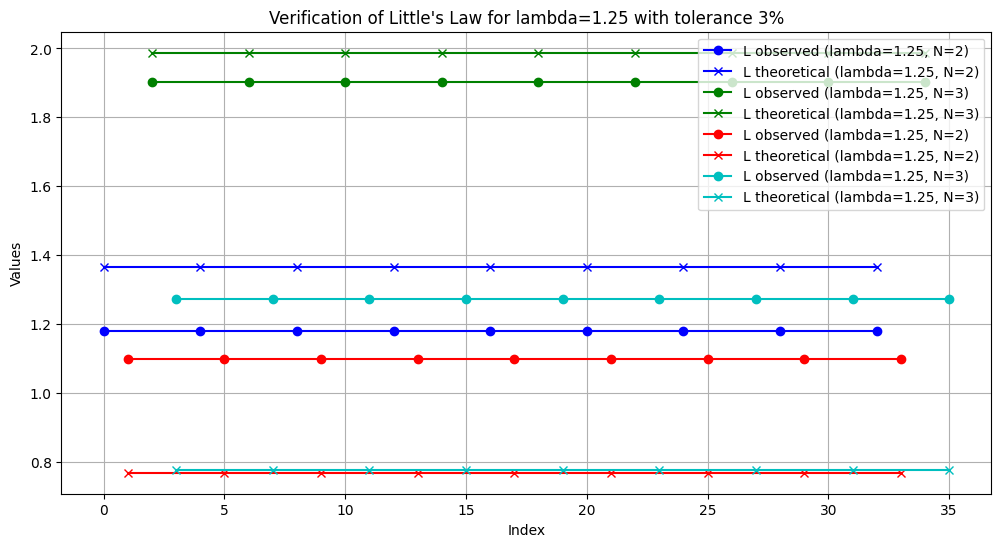

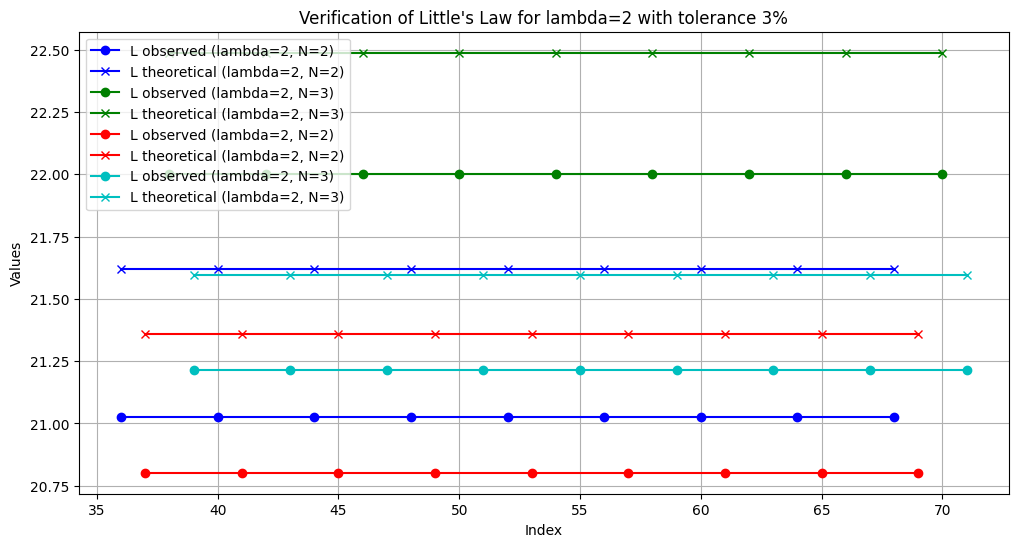

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=2|N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Estrai i valori di lambda dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)

# Calcola le colonne L osservato e L teorico usando le medie delle lunghezze delle code
results_df['L_observed'] = results_df['mean_queueLength_Q1'] + results_df['mean_queueLength_Q2']
results_df['L_theoretical'] = results_df['lambda'] * results_df['mean_W']
results_df['L_difference'] = abs(results_df['L_observed'] - results_df['L_theoretical'])
results_df['percentage_L_difference'] = (results_df['L_difference'] / results_df['L_observed']) * 100

# Verifica del teorema di Little con tolleranza
tolerance = 3  # Tolleranza del 3%
results_df['little_verification'] = results_df.apply(lambda row: row['percentage_L_difference'] < tolerance, axis=1)

# Salva i risultati in un file CSV
results_df.to_csv('LittleLaw_results.csv', index=False)

# Mostra i risultati per debug
print(results_df[['File', 'N_value', 'Strategy', 'mean_W', 'L_observed', 'L_difference', 'percentage_L_difference', 'little_verification']])

# Grafico per verificare il teorema di Little per ciascuna strategia
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Lista di colori
for lambda_value in [1.25, 2]:
    plt.figure(figsize=(12, 6))
    subset = results_df[results_df['lambda'] == lambda_value]
    color_index = 0
    for strategy in subset['Strategy'].unique():
        for n in [2, 3]:
            subsubset = subset[(subset['N_value'] == n) & (subset['Strategy'] == strategy)]
            if not subsubset.empty:
                color = colors[color_index % len(colors)]  # Seleziona il colore
                color_index += 1
                plt.plot(subsubset.index, subsubset['L_observed'], label=f'L observed (lambda={lambda_value}, N={n})', marker='o', linestyle='-', color=color)
                plt.plot(subsubset.index, subsubset['L_theoretical'], label=f'L theoretical (lambda={lambda_value}, N={n})', marker='x', linestyle='-', color=color)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Verification of Little\'s Law for lambda={lambda_value} with tolerance {tolerance}%')
    plt.legend()
    plt.grid(True)
    plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.png')
    plt.savefig('Convalidation_Images/' + plt.gca().get_title() + '.eps')  
plt.show()


General lambda: 1.9477684020996096
        File  N_value   Strategy     mean_W  L_observed  \
0    Config1        2    Exact_N   1.093466    1.179034   
1    Config2        2  Limited_N   0.615561    1.099829   
2    Config3        3    Exact_N   1.589997    1.902170   
3    Config4        3  Limited_N   0.621560    1.273289   
4    Config5        2    Exact_N   1.093466    1.179034   
..       ...      ...        ...        ...         ...   
67  Config68        3  Limited_N  10.797922   21.214235   
68  Config69        2    Exact_N  10.810406   21.025092   
69  Config70        2  Limited_N  10.680184   20.802443   
70  Config71        3    Exact_N  11.243851   22.000611   
71  Config72        3  Limited_N  10.797922   21.214235   

    L_theoretical_general  L_difference  percentage_L_difference  \
0                2.129818      0.950785                80.641040   
1                1.198971      0.099142                 9.014337   
2                3.096945      1.194775             

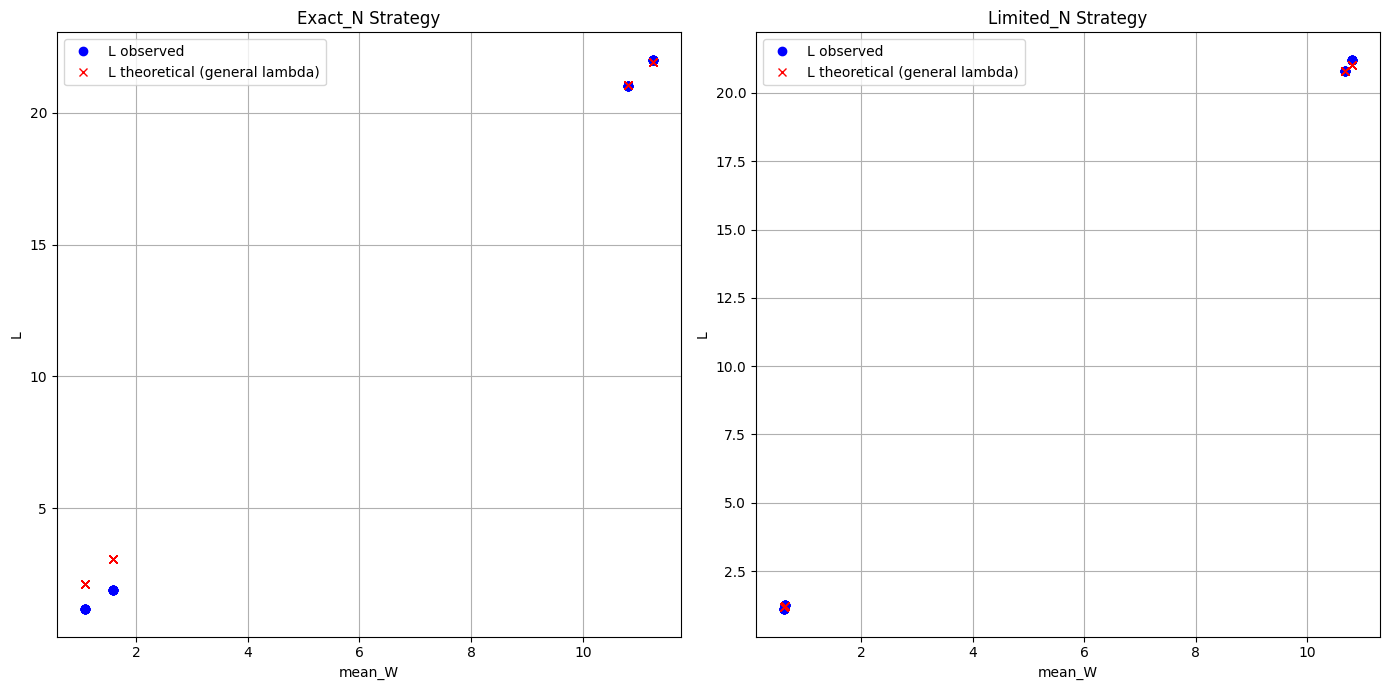

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.optimize import minimize

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Funzione obiettivo generale per minimizzare la somma delle differenze tra L osservato e L teorico su tutte le simulazioni
def general_objective_function(lambda_val, mean_W, L_observed):
    L_theoretical = lambda_val * mean_W
    return np.sum(np.abs(L_theoretical - L_observed))

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=2|N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Estrai i valori di lambda dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)

# Calcola la colonna L osservato
results_df['L_observed'] = results_df['mean_queueLength_Q1'] + results_df['mean_queueLength_Q2']

# Array di mean_W e L_observed per tutte le simulazioni
mean_W_all = results_df['mean_W'].values
L_observed_all = results_df['L_observed'].values

# Ottimizzazione per trovare il valore generale di lambda
result = minimize(general_objective_function, np.mean(results_df['lambda']), args=(mean_W_all, L_observed_all), method='Nelder-Mead')
general_lambda = result.x[0]

# Calcola L teorico con lambda generale
results_df['L_theoretical_general'] = general_lambda * results_df['mean_W']

# Calcola la differenza assoluta e percentuale tra L osservato e L teorico
results_df['L_difference'] = abs(results_df['L_observed'] - results_df['L_theoretical_general'])
results_df['percentage_L_difference'] = (results_df['L_difference'] / results_df['L_observed']) * 100

# Verifica del teorema di Little con lambda generale
tolerance = 1
results_df['little_verification_general'] = results_df.apply(lambda row: row['percentage_L_difference'] < tolerance, axis=1)

# Salva i risultati in un file CSV
results_df.to_csv('LittleLaw_general_lambda_results.csv', index=False)

# Mostra i risultati per debug
print(f"General lambda: {general_lambda}")
print(results_df[['File', 'N_value', 'Strategy', 'mean_W', 'L_observed', 'L_theoretical_general', 'L_difference', 'percentage_L_difference', 'little_verification_general']])

# Grafico per verificare il teorema di Little per ciascuna strategia con lambda generale

# Separazione dei dati per le due strategie
exact_N_data = results_df[results_df['Strategy'] == 'Exact_N']
limited_N_data = results_df[results_df['Strategy'] == 'Limited_N']

# Creazione del grafico per le strategie
plt.figure(figsize=(14, 7))

# Grafico per Exact_N
plt.subplot(1, 2, 1)
plt.plot(exact_N_data['mean_W'], exact_N_data['L_observed'], 'o', label='L observed', color='blue')
plt.plot(exact_N_data['mean_W'], exact_N_data['L_theoretical_general'], 'x', label='L theoretical (general lambda)', color='red')
plt.xlabel('mean_W')
plt.ylabel('L')
plt.title('Exact_N Strategy')
plt.legend()
plt.grid(True)

# Grafico per Limited_N
plt.subplot(1, 2, 2)
plt.plot(limited_N_data['mean_W'], limited_N_data['L_observed'], 'o', label='L observed', color='blue')
plt.plot(limited_N_data['mean_W'], limited_N_data['L_theoretical_general'], 'x', label='L theoretical (general lambda)', color='red')
plt.xlabel('mean_W')
plt.ylabel('L')
plt.title('Limited_N Strategy')
plt.legend()
plt.grid(True)

# Visualizzazione del grafico
plt.tight_layout()
plt.show()
